In [1]:
from PIL import Image
import torchvision
import torch
import numpy as np
import os
from studentnets import TinyNet
import transforms as T
import utils
import matplotlib.pyplot as plt
from torch import nn
import time
import datetime
from torch.utils.data.sampler import SubsetRandomSampler
import cv2

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

teacher network

In [3]:
teacher_network = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
teacher_network = teacher_network.to(device)

student network

In [4]:
student_network = TinyNet(device, 2).to(device)

load images

In [5]:
img_paths = "/media/yalu/6066C1DD66C1B3D6/images/cam{}"
cams_num = 2

dataset

In [6]:
class teacherDataset(object):
    def __init__(self, root, cams_num, transforms=None):
        self.root = root
        self.transforms = transforms
        
        self.imgs = []
        for cam_id in range(cams_num):
            img_root = self.root.format(cam_id)
            img_names = sorted(os.listdir(img_root))
            self.imgs += [os.path.join(img_root, img_name) for img_name in img_names]
        
    def __getitem__(self, idx):
        
        img_path = self.imgs[idx]
        img = Image.open(img_path)
        img = np.array(img.convert("RGB"))
        target = {}
        if self.transforms is not None:
            img, _ = self.transforms(img, target)
#             try:
#                 img.verify()
#                 img = np.array(img.convert("RGB"))
#                 target = {}
#                 if self.transforms is not None:
#                     img, _ = self.transforms(img, target)
#                 break
#             except Exception:
#                 print('Invalid image on {}'.format(img_path))
#                 idx = 0
#                 continue
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [7]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
def genMask(output, score_th = 0.9, mask_th = 0.2, CUDA = True):
    scores = output["scores"]
    masks = output["masks"]
    labels = output["labels"]
    mask_out = torch.sum(masks[(scores > score_th) & (labels == 1)], 0)
    mask_out = torch.squeeze(mask_out > mask_th)
    return mask_out

In [9]:
def criterion(input, target):
    loss = nn.functional.cross_entropy(input, target, ignore_index=255)
    return loss

In [10]:
my_dataset = teacherDataset(img_paths, cams_num, get_transform(train=False))

validation_split = 0.1

dataset_len = len(my_dataset)
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor(validation_split * dataset_len))
validation_idx = np.random.choice(indices, size=val_len, replace=False)
train_idx = list(set(indices) - set(validation_idx))

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader = torch.utils.data.DataLoader(my_dataset, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(my_dataset, sampler=validation_sampler)
data_loaders = {"train": train_loader, "val": validation_loader}
data_lengths = {"train": len(train_idx), "val": val_len}

In [11]:
optimizer = torch.optim.SGD(
    student_network.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4)

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda x: (1 - x / (len(train_idx) * 100)) ** 0.9)

In [12]:
# teacher_network.eval()

# for i in range(3):
#     for epoch in range(1, epochs):
#         tDataset = teacherDataset(data_root, epoch, get_transform(train=False))
#         data_loader_teacher = torch.utils.data.DataLoader(
#                 tDataset, batch_size=b_size, shuffle=True, num_workers=4,
#                 collate_fn=utils.collate_fn)
#         print("epoch -- ", epoch)
#         step_loss = []
#         start_time = time.time()
#         for image, target in data_loader_teacher:
#             image = image.to(device)
#             outputs = teacher_network(list(image.unbind(0)))

#             # generate teacher output as student target
#             T_seg = [genMask(output) for output in outputs]
#             T_seg = torch.stack(T_seg).long()

#             # student network infer
#             student_out = student_network.forward(image)


#             # train student network
#             loss = criterion(student_out, T_seg)
#             step_loss.append(loss.item())
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             lr_scheduler.step()

#         print("step loss : ", np.mean(step_loss))
#         total_time = time.time() - start_time
#         total_time_str = str(datetime.timedelta(seconds=int(total_time)))
#         print('time cost : {}'.format(total_time_str))

In [13]:
n_epochs = 2


teacher_network.eval()
for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            student_network.train(True)  # Set model to training mode
        else:
            student_network.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        step_loss = []
        # Iterate over data.
        for image, target in data_loaders[phase]:
            image = image.to(device)
            outputs = teacher_network(list(image.unbind(0)))

            # generate teacher output as student target
            T_seg = [genMask(output) for output in outputs]
            T_seg = torch.stack(T_seg).long()

            # student network infer
            student_out = student_network.forward(image)
            loss = criterion(student_out, T_seg)
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            # print loss statistics
            running_loss += loss.item()
            print("*", end = "")

        epoch_loss = running_loss / data_lengths[phase]
        print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 0/1
----------
***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************train Loss: 0.0829
***********************************************************************************************val Loss: 

get tensor from image

In [14]:
#image = Image.open("cam1.jpg").convert("RGB")
image = cv2.imread("cam1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

img_tensor = torchvision.transforms.functional.to_tensor(image).cuda()
img_tensor = img_tensor.to(device)
img_tensor = img_tensor.reshape(1,3,720,1280)

(720, 1280, 3)


In [15]:
teacher_infer_start_time = time.time()
teacher_out = teacher_network(list(img_tensor.unbind(0)))
teacher_infer_time = time.time() - teacher_infer_start_time
teacher_infer_time_str = str(datetime.timedelta(milliseconds=teacher_infer_time/1))
print('teacher infer time cost : {} '.format(teacher_infer_time_str))

teacher infer time cost : 0:00:00.000205 


In [16]:
# generate teacher output as student target
T_seg = [genMask(output) for output in teacher_out]
T_seg = torch.stack(T_seg).long()

In [17]:
student_infer_start_time = time.time()
student_out = student_network.forward(img_tensor)
student_infer_time = time.time() - student_infer_start_time
student_infer_time_str = str(datetime.timedelta(milliseconds=student_infer_time/1))
print('student infer time cost : {}'.format(student_infer_time_str))

student infer time cost : 0:00:00.000005


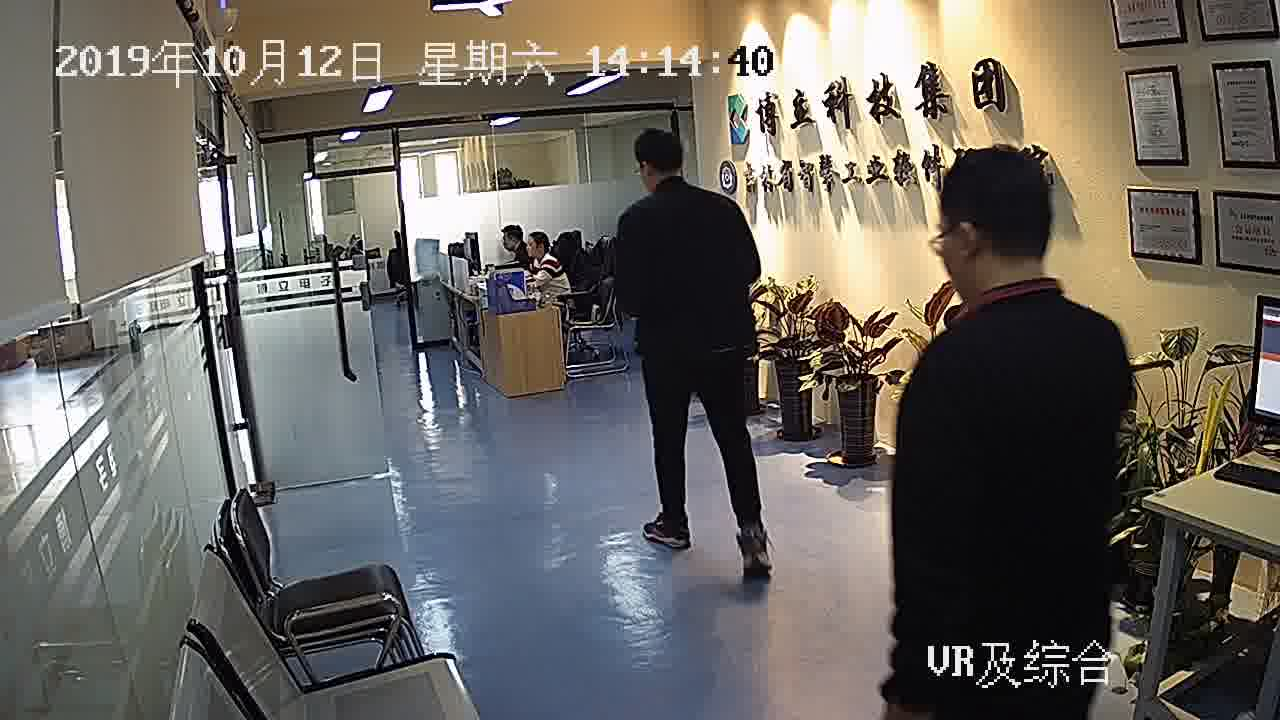

In [18]:
torchvision.transforms.ToPILImage()(img_tensor[0].cpu())

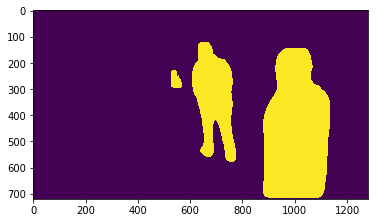

In [19]:
plt.imshow(T_seg[0].cpu().detach().numpy())

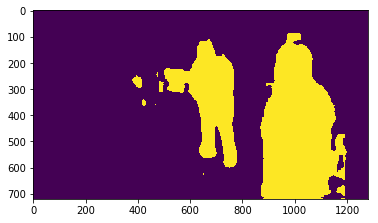

In [20]:
plt.imshow(student_out[0].cpu().detach().numpy()[0] < 0.1)

In [21]:
torch.save(student_network,'student.pkl')